# **Importing Libraries**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from tqdm import tqdm
import re
import nltk
from bs4 import BeautifulSoup
from nltk.tag import pos_tag
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [17]:
data = pd.read_csv("/content/labeledTrainData.tsv.zip", header=0, delimiter="\t", quoting=3)

In [18]:
data.drop('id',inplace=True,axis=1)
data_copy=data.copy(deep=True)
data.head()

,sentiment,review
0,1,"""With all this stuff going down at the moment ..."
1,1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,0,"""The film starts with a manager (Nicholas Bell..."
3,0,"""It must be assumed that those who praised thi..."
4,1,"""Superbly trashy and wondrously unpretentious ..."


In [19]:
print('-----SHAPE OF THE DATASET-----')
data.shape

-----SHAPE OF THE DATASET-----


(25000, 2)

In [20]:
print('-----DISTRIBUTION OF DATASET-----')
data['sentiment'].value_counts()

-----DISTRIBUTION OF DATASET-----


1    12500
0    12500
Name: sentiment, dtype: int64

# **Nan/Null Value and Duplicate Checks**

In [21]:
print("We have {} NaN/Null values in dataset ".format(data.isnull().values.sum()))
print("Number of duplicate in  dataset : {} ".format(sum(data['review'].duplicated())))

We have 0 NaN/Null values in dataset 
Number of duplicate in  dataset : 96 


In [22]:
#removing duplicate rows
print('REMOVING DUPLICATE ROWS....')
data=data.drop_duplicates(subset={'review'}, keep='first', inplace=False)
data.shape

REMOVING DUPLICATE ROWS....


(24904, 2)

*   From the above samples of data we can understand ,it is mandatory to clean the data

# **Data Preprocessing**

**Decontracting the words**

In [23]:
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

**Removing all urls from data, Removing all tags from data, Decontracting the words, Removing special character from data, Removing stop words**

In [24]:
nltk.download('stopwords')
eng_stopwords = set(stopwords.words('english'))
def cleaning(data):
  preprocessed_reviews = []
  for sentance in tqdm(data['review'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in eng_stopwords) 
    preprocessed_reviews.append(sentance.strip())
  data['review']=preprocessed_reviews
  return data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
data_after_cleaning=cleaning(data) #dataframe after cleaning
#data_after_cleaning.to_csv('after_cleaning.csv')# saving csv file

100%|██████████| 24904/24904 [00:18<00:00, 1337.41it/s]


**Featurization of data**

In [26]:
X=data_after_cleaning['review']
Y=data_after_cleaning['sentiment']
print(X.shape)
print(Y.shape)

(24904,)
(24904,)


In [28]:
X

0        stuff going moment mj started listening music ...
1        classic war worlds timothy hines entertaining ...
2        film starts manager nicholas bell giving welco...
3        must assumed praised film greatest filmed oper...
4        superbly trashy wondrously unpretentious explo...
                               ...                        
24995    seems like consideration gone imdb reviews fil...
24996    believe made film completely unnecessary first...
24997    guy loser ca get girls needs build picked stro...
24998    minute documentary bu uel made early one spain...
24999    saw movie child broke heart story unfinished e...
Name: review, Length: 24904, dtype: object

In [29]:
Y

0        1
1        1
2        0
3        0
4        1
        ..
24995    0
24996    0
24997    0
24998    0
24999    1
Name: sentiment, Length: 24904, dtype: int64

In [27]:
# Unique Word Count
len(set(" ".join(list(X.values)).split()))

74460

In [30]:
# splitting into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25,random_state=42)
print('TRAIN DATA - ',X_train.shape)
print('\n')
print('TEST DATA - ',X_test.shape)

TRAIN DATA -  (18678,)


TEST DATA -  (6226,)


For text data Featurization we can use different types of techniques, here we use mainly 2 types
*   Bag of words(with ngrams)
*   Tf-Idf

**TF-Idf**

In [31]:
#tfidf
tfidfvectorizer = TfidfVectorizer(min_df=10,max_features=20000)
text_tfidf = tfidfvectorizer.fit(X_train.values) #fitting

X_train_tfidf =tfidfvectorizer.transform(X_train.values) 
X_test_tfidf =tfidfvectorizer.transform(X_test.values)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(18678, 15344) (18678,)
(6226, 15344) (6226,)


In [ ]:
#Save tfidfvectorizer to pickle

#pickle.dump(tfidfvectorizer, open("tfidfvectorizer.pkl","wb"))

# **Modeling**

*   For modelling we use only tf-idf vectorized data only.



In [32]:
# Support Vector Machine

from sklearn import svm
svm = svm.SVC()
svm.fit(X_train_tfidf, y_train)
print("Accuracy: ",(accuracy_score(y_test,svm.predict(X_test_tfidf))))

Accuracy:  0.8925473819466753


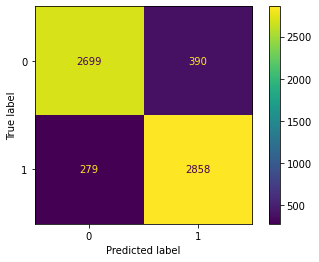

In [33]:
metrics.plot_confusion_matrix(svm, X_test_tfidf, y_test)

In [34]:
#Gausian Naive Bayes

from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB.fit(X_train_tfidf.toarray(), y_train)
print("Accuracy: ",(accuracy_score(y_test,GNB.predict(X_test_tfidf.toarray()))))

Accuracy:  0.7640539672341793


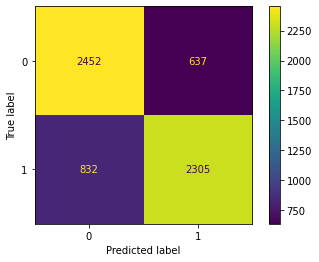

In [35]:
metrics.plot_confusion_matrix(GNB, X_test_tfidf.toarray(), y_test)

In [36]:
#Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
sgd.fit(X_train_tfidf, y_train)
print("Accuracy: ",(accuracy_score(y_test,sgd.predict(X_test_tfidf))))

Accuracy:  0.8920655316415034


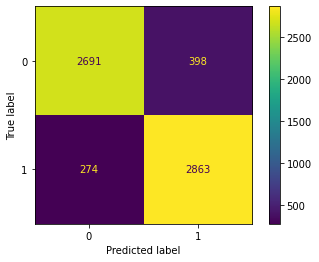

In [37]:
metrics.plot_confusion_matrix(sgd, X_test_tfidf, y_test)

In [38]:
#Ridge Classifier
from sklearn.linear_model import RidgeClassifier
rc = RidgeClassifier()
rc.fit(X_train_tfidf, y_train)
print("Accuracy: ",(accuracy_score(y_test,rc.predict(X_test_tfidf))))

Accuracy:  0.8821072920012849


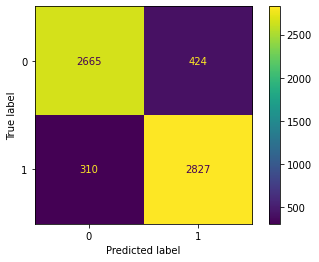

In [39]:
metrics.plot_confusion_matrix(rc, X_test_tfidf, y_test)

In [40]:
#Decision Tree
from sklearn import tree
decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(X_train_tfidf, y_train)
print("Accuracy: ",(accuracy_score(y_test,decision_tree.predict(X_test_tfidf))))

Accuracy:  0.7166720205589463


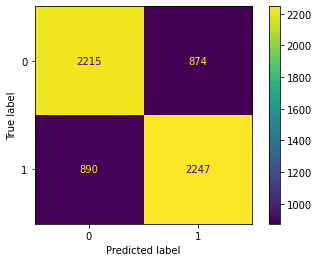

In [41]:
metrics.plot_confusion_matrix(decision_tree, X_test_tfidf, y_test)

In [42]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
print("Accuracy: ",(accuracy_score(y_test,lr.predict(X_test_tfidf))))

Accuracy:  0.8891744298104722


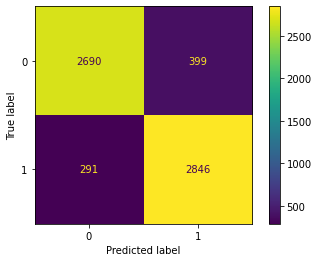

In [43]:
metrics.plot_confusion_matrix(lr, X_test_tfidf, y_test)

***We use Model SGDClassifier for Deployment***

In [45]:
#Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

for feat in range(1000, 20000, 2000):
  tfidfvectorizer = TfidfVectorizer(min_df=10,max_features=feat)
  text_tfidf = tfidfvectorizer.fit(X_train.values) #fitting

  X_train_tfidf =tfidfvectorizer.transform(X_train.values) 
  X_test_tfidf =tfidfvectorizer.transform(X_test.values)

  sgd = SGDClassifier()
  sgd.fit(X_train_tfidf, y_train)
  print(feat, "Accuracy: ",(accuracy_score(y_test,sgd.predict(X_test_tfidf))))

1000 Accuracy:  0.8581753935110825
3000 Accuracy:  0.8771281721811757
5000 Accuracy:  0.8837134596851911
7000 Accuracy:  0.8901381304208159
9000 Accuracy:  0.8893350465788629
11000 Accuracy:  0.8890138130420816
13000 Accuracy:  0.8896562801156441
15000 Accuracy:  0.8920655316415034
17000 Accuracy:  0.8928686154834564
19000 Accuracy:  0.8919049148731127


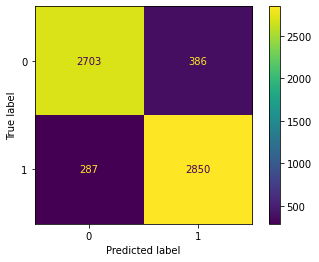

In [46]:
metrics.plot_confusion_matrix(sgd, X_test_tfidf, y_test)

In [ ]:
#Save tfidfvectorizer 19k features and save model SGD Classifier

#pickle.dump(tfidfvectorizer, open("tfidfvectorizer_19k.pkl","wb"))
#pickle.dump(sgd, open("model_sgd.pkl","wb"))

In [47]:
from sklearn.linear_model import LogisticRegression

for feat in range(1000, 20000, 2000):
  tfidfvectorizer = TfidfVectorizer(min_df=10,max_features=feat)
  text_tfidf = tfidfvectorizer.fit(X_train.values) #fitting

  X_train_tfidf =tfidfvectorizer.transform(X_train.values) 
  X_test_tfidf =tfidfvectorizer.transform(X_test.values)

  lr = LogisticRegression()
  lr.fit(X_train_tfidf, y_train)
  print(feat,"Accuracy: ",(accuracy_score(y_test,lr.predict(X_test_tfidf))))

1000 Accuracy:  0.8589784773530357
3000 Accuracy:  0.8779312560231288
5000 Accuracy:  0.8822679087696755
7000 Accuracy:  0.8862833279794411
9000 Accuracy:  0.8882107292001284
11000 Accuracy:  0.8885319627369097
13000 Accuracy:  0.888853196273691
15000 Accuracy:  0.8890138130420816
17000 Accuracy:  0.8891744298104722
19000 Accuracy:  0.8891744298104722


In [51]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
for k in range(1000, 1101, 10):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_tfidf, y_train)
  print(k, "Accuracy: ",(accuracy_score(y_test,knn.predict(X_test_tfidf))))

1000 Accuracy:  0.8103115965306779
1010 Accuracy:  0.8104722132990684
1020 Accuracy:  0.8099903629938966
1030 Accuracy:  0.8120783809829746
1040 Accuracy:  0.8107934468358496
1050 Accuracy:  0.8112752971410215
1060 Accuracy:  0.8095085126887247
1070 Accuracy:  0.8107934468358496
1080 Accuracy:  0.8096691294571153
1090 Accuracy:  0.8093478959203341
1100 Accuracy:  0.8090266623835528


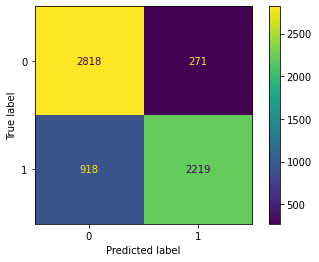

In [52]:
metrics.plot_confusion_matrix(knn, X_test_tfidf, y_test)

In [53]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
print("Accuracy: ",(accuracy_score(y_test,rf.predict(X_test_tfidf))))

Accuracy:  0.8530356569225828


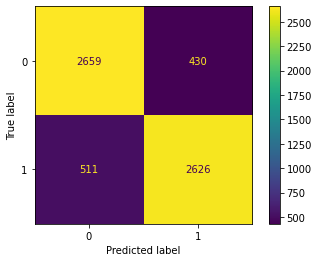

In [ ]:
metrics.plot_confusion_matrix(rf, X_test_tfidf, y_test)